In [1]:
# adjust the output to full width
from IPython.display import HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# make changes to imported files immidiately available 
# avoiding the need to reload (in most cases)
%load_ext autoreload
%autoreload 2

This illustrative notebook shows how to create a representation for a new model.

For the sake of simplicity we assume here that we start with a description of pools and fluxes.
This is the form the models are usually described in the literature.
We will see that the framework can derive a matrix representation automatically. 

It would also be possible to start from the matrices or even
mix the two approaches. 
We will point to some more advanced examples where you can see this in action. If you get familiar with the framework you will find many more combinations than we can cover. 

## Inspect a minimal model

We will start with an extremely simple model.
whose original you can find in 
```bash
bgc_md2/src/bgc_md2/models/testVectorFree/source.py
```
or via the following code:

In [2]:
import inspect
import bgc_md2.models.testVectorFree.source 
print(inspect.getsource(bgc_md2.models.testVectorFree.source))

from sympy import symbols
from ComputabilityGraphs.CMTVS import CMTVS
from bgc_md2.helper import bgc_md2_computers
from bgc_md2.resolve.mvars import (
    InFluxesBySymbol,
    OutFluxesBySymbol,
    InternalFluxesBySymbol,
    TimeSymbol,
    StateVariableTuple,
)

I_vl, I_vw = symbols("I_vl I_vw")
vl, vw = symbols("vl vw")
k_vl, k_vw = symbols("k_vl k_vw")


mvs = CMTVS(
    {
        StateVariableTuple((vl, vw)),
        TimeSymbol("t"),
        InFluxesBySymbol({vl: I_vl, vw: I_vw}),
        OutFluxesBySymbol({vl: k_vl * vl, vw: k_vw * vw}),
        InternalFluxesBySymbol({(vl, vw): k_vl * vl, (vw, vl): k_vw * vw}),
    },
    bgc_md2_computers()

)



copy its contents into a new cell. (we can later save it under a new name) 

In [3]:

from sympy import var, Symbol, Function 
from ComputabilityGraphs.CMTVS import CMTVS
from ComputabilityGraphs.helpers import module_computers
#from bgc_md2.helper import module_computers
from bgc_md2.resolve.mvars import (
    InFluxesBySymbol,
    OutFluxesBySymbol,
    InternalFluxesBySymbol,
    TimeSymbol,
    StateVariableTuple,
)
from importlib import import_module

# Make a small dictionary for the variables we will use
sym_dict={
    "leaf": "vegegation leaf pool",
    "wood": "vegetation wood pool content",
    "I_wood": "Influx into vegetation wood pool",
    "k_wood_o": "out flux rate of wood pool",
    "k_leaf_2_wood": "constant internal flux rate from leaf to wood", 
    "k_wood_2_leaf": "constant internal flux rate from wood to leaf", 
}
# Make symbols from  the strings that we can later use in expressions  
# leaf, wood,...
for k in sym_dict.keys():
    code=k+" = Symbol('{0}')".format(k)
    exec(code)

# We will also use some symbolic functions ("symbols" with an argument) 
func_dict={
    "I_leaf": "Influx into vegetation leaf pool",
    "k_leaf_o": "out flux rate of leaf pool",
}
for k in func_dict.keys():
    code=k+" = Function('{0}')".format(k)
    exec(code)

t=TimeSymbol("t")

mvs = CMTVS(
    {
        StateVariableTuple((leaf, wood)),
        t,
        InFluxesBySymbol({leaf: I_leaf(t), wood: I_wood}),
        OutFluxesBySymbol({leaf: k_leaf_o(t) * leaf, wood: k_wood_o * wood}),
        InternalFluxesBySymbol({(leaf, wood): k_leaf_2_wood * leaf, (wood, leaf): k_wood_2_leaf * wood}),
    },

    computers=module_computers(bgc_md2.resolve.computers)
)

The last statement in the code defines a variable `mvs` which is 
an instance of CMTVS which stands for `C`onnected`M`ulti`T`ype`V`ariable`S`et".
It contains information in two forms. 
1. Variables of certain types (like InFluxesBySymbol)
2. Computers, Functions that "connect" these Variables and to other results we did not specify but which can be computed.
   


Tasks:
To see what it can do with this information add a new cell an type `mvs.` and press the `tab` key `->`. This will show you the available methods, in other words what can be computed from the provided information.

I wanted to see the compartmental the pools, the matrix and the inputs.

In [4]:
mvs.get_CompartmentalMatrix()

{CompartmentalMatrix,OutputTuple,InputTuple}
{OutFluxesBySymbol,InputTuple,InFluxesBySymbol,CompartmentalMatrix,OutputTuple,SmoothReservoirModel,InternalFluxesBySymbol}
{OutFluxesBySymbol,InputTuple,InFluxesBySymbol,CompartmentalMatrix,OutputTuple,SmoothReservoirModel,InternalFluxesBySymbol}


Matrix([
[-k_leaf_2_wood - k_leaf_o(t),             k_wood_2_leaf],
[               k_leaf_2_wood, -k_wood_2_leaf - k_wood_o]])

In [5]:
mvs.get_CompartmentalMatrix()

Matrix([
[-k_leaf_2_wood - k_leaf_o(t),             k_wood_2_leaf],
[               k_leaf_2_wood, -k_wood_2_leaf - k_wood_o]])

In [6]:
mvs.get_InputTuple()

Matrix([
[I_leaf(t)],
[   I_wood]])

In [7]:
# we can also print the whole mass balance equation
import bgc_md2.display_helpers as dh
dh.mass_balance_equation(mvs)

<IPython.core.display.Math object>

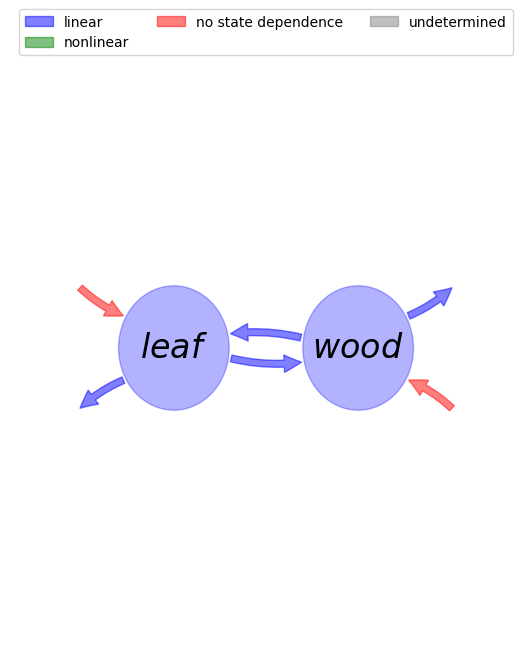

In [8]:
# we can also plot a picture
import bgc_md2.helper as h
h.compartmental_graph(mvs)

## Extend the minimal model

### Add more state variables and fluxes for soil pools
Task:
Add new pools for litter (slit), coarse woody debris (scwd) and soil organic matter (som)
and fluxes from the vegetation pools to the new pools.

To avoid (at the moment) unintelligibleerror messages from the depth of the package, go in small steps:
- first add only a new symbol (e.g. for a new pool), 
- then add the pool to StateVariableTuple
- then add a new symbol for a fluxrate or a symbolic function  
- then add the flux using the rates 
- repeat with the next pool,flux

The result will look some what like this:

In [9]:
# Make a small dictionary for the variables we will use
sym_dict={
    "leaf": "vegegation leaf pool",
    "wood": "vegetation wood pool content",
    "lit":"soil litter pool",
    "som": "soil organic litter",
    "cwd": "soil coarse woody debris",
    "I_wood": "Influx into vegetation wood pool",
    "k_wood_o": "out flux rate of wood pool",
    "k_som_o": "out flux rate of som pool",
    "k_leaf_2_wood": "constant internal flux rate from leaf to wood", 
    "k_wood_2_leaf": "constant internal flux rate from wood to leaf", 
    "k_leaf_2_lit": "flux rate from leaf to litter",
    "k_wood_2_cwd": "flux rate from wood to coarse woody debris",
    "k_lit_2_som": "flux rate from litter to som",
    "k_cwd_2_som": "flux rate from coarse woody debris to som",
}
# Make symbols from  the strings that we can later use in expressions  
# leaf, wood,...
for k in sym_dict.keys():
    code=k+" = Symbol('{0}')".format(k)
    exec(code)

# We will also use some symbolic functions ("symbols" with an argument) 
func_dict={
    "I_leaf": "Influx into vegetation leaf pool",
    "k_leaf_o": "out flux rate of leaf pool",
}
for k in func_dict.keys():
    code=k+" = Function('{0}')".format(k)
    exec(code)

t=TimeSymbol("t")

mvs = CMTVS(
    {
        StateVariableTuple((leaf, wood, lit, cwd, som)),
        t,
        InFluxesBySymbol({leaf: I_leaf(t), wood: I_wood}),
        OutFluxesBySymbol({
            leaf: k_leaf_o(t) * leaf,
            wood: k_wood_o * wood,
            som: k_som_o * som,
        }),
        InternalFluxesBySymbol({
            (leaf, wood): k_leaf_2_wood * leaf, 
            (wood, leaf): k_wood_2_leaf * wood,
            (leaf, lit): k_leaf_2_lit * leaf,
            (wood, cwd): k_wood_2_cwd * wood,
            (lit, som): k_lit_2_som *lit,
            (cwd, som): k_cwd_2_som *cwd,
        }),
    },

    computers=module_computers(bgc_md2.resolve.computers)
)

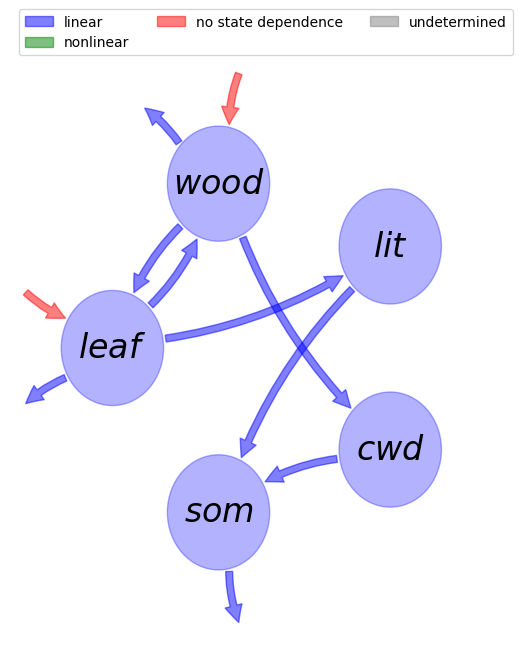

In [10]:
h.compartmental_graph(mvs)

### Task: Compute the aggregated flux from the vegetation to soil compartments.
We want to decompose the model into a soil and vegetation part specify the pools belonging to  vegetation  and soil. 
We show how do it by hand first and then use ComputabilityGraphs to show us the shortcuts.
#### manual Approach

In [11]:
vcsvt = (wood,leaf)
scsvt = (lit, som, cwd)
# find the internal fluxes that have a vegetation pool as source and a soil pool target
v2sfls= {k:v for k,v in mvs.get_InternalFluxesBySymbol().items() if (k[0] in vcsvt and k[1] in scsvt) }

# find the internal fluxes that have a vegetation pool as source and a soil pool target
s2vfls= {k:v for k,v in mvs.get_InternalFluxesBySymbol().items() if (k[0] in scsvt and k[1] in vcsvt) }
v2sfls,s2vfls

# now we can sum those fluxes up
v2sAgg = sum(
    v2sfls.values()
)
s2vAgg = sum (
    s2vfls.values()
)
v2sAgg,s2vAgg


(k_leaf_2_lit*leaf + k_wood_2_cwd*wood, 0)

#### Use ComputatbilityGraphs

1. To find out what `mvars` are available to describe what we know about the model we first look at all potentially computable properties.
1. We pick one with a promising name and check if it is available. 

In [12]:
import ComputabilityGraphs.helpers as cgh
computers=module_computers(bgc_md2.resolve.computers)
types=cgh.all_mvars(computers)

Since we are interested in the Fluxes from the Vegetation part to the soil Part, *AggregatedVegetation2SoilCarbonFlux* sounds promising.
Let's look up the documentation:

In [13]:
#?bgc_md2.resolve.mvars.AggregatedVegetation2SoilCarbonFlux

We now use the `ComputabilityGraphs` package to find out what information (mvars) we have to provide to compute the `AggregatedVegetation2SoilCarbonFlux`

In [14]:

ca=h.numbered_aliases("f",computers)
ta=h.numbered_aliases("T",types)
ta

(frozendict.frozendict({<class 'bgc_md2.resolve.mvars.CarbonInputPartitioningTuple'>: 'T0', <class 'bgc_md2.resolve.mvars.CarbonInternalFluxesBySymbol'>: 'T1', <class 'bgc_md2.resolve.mvars.NumericParameterization'>: 'T2', <class 'bgc_md2.resolve.mvars.InternalFluxesBySymbol'>: 'T3', <class 'bgc_md2.resolve.mvars.SoilCarbonStateVariableTuple'>: 'T4', <class 'bgc_md2.resolve.mvars.AggregatedVegetationCarbonInFlux'>: 'T5', <class 'bgc_md2.resolve.mvars.QuantityParameterizedSmoothReservoirModel'>: 'T6', <class 'bgc_md2.resolve.mvars.NumericStartValueDict'>: 'T7', <class 'bgc_md2.resolve.mvars.CarbonInputTuple'>: 'T8', <class 'bgc_md2.resolve.mvars.CarbonInFluxesBySymbol'>: 'T9', <class 'bgc_md2.resolve.mvars.InFluxesBySymbol'>: 'T10', <class 'bgc_md2.resolve.mvars.VegetationCarbonOutFluxesBySymbol'>: 'T11', <class 'bgc_md2.resolve.mvars.LuoXiBySymbol'>: 'T12', <class 'bgc_md2.resolve.mvars.NumericCompartmentalMatrixSolutionTuple'>: 'T13', <class 'bgc_md2.resolve.mvars.NitrogenCompartmenta

In [47]:
import ComputabilityGraphs.or_graph_helpers as ogh
from bgc_md2.resolve.mvars import AggregatedVegetation2SoilCarbonFlux

og=ogh.t_tree(
    root_type=AggregatedVegetation2SoilCarbonFlux,
    available_computers=computers,
    avoid_types=frozenset({}),
    #given_types=mvs.provided_mvar_types
)
#import matplotlib.pyplot as plt
#ax=plt.subplot()
#og.to_networkx_graph(avoid_types=ogh.TypeSet({})).draw_matplotlib(ax)
og.psts

AltSet({
	TypeSet({VegetationCarbonStateVariableTuple,CompartmentalMatrix,StateVariableTuple,SoilCarbonStateVariableTuple})
})

In [60]:
og.jupyter_widget(
    computer_aliases_tup=ca,
    type_aliases_tup=ta,
    given=mvs.provided_mvar_types
)

In [61]:
import matplotlib.pyplot as plt
from ComputabilityGraphs.dep_graph_helpers import ( 
    #duplicated_computer_dict, 
    all_dep_graphs
)
root=bgc_md2.resolve.mvars.AggregatedVegetation2SoilCarbonFlux
cs=computers
gs= set(
    all_dep_graphs(
        root_type=root,
        cs=cs,
        #given=frozenset()
        given=mvs.provided_mvar_types
    )
)
len(gs)

1

In [18]:
#n=len(gs)
#fig=plt.figure(figsize=(20,20*n))
#if n>1:
#    axs = fig.subplots(n,1)
#    for i,ax in enumerate(axs):
#        dg = list(gs)[i]
#        dg.draw_matplotlib(ax)
#else:
#    dg=list(gs)[0]
#    ax=fig.subplots(1,1)
#    dg.draw_matplotlib(ax)
#fig.savefig("depgraphs_" + root.__name__ + '.pdf')
#dg.required_mvars(given=mvs.provided_mvar_types)


type(mvs.provided_mvar_types)

frozenset

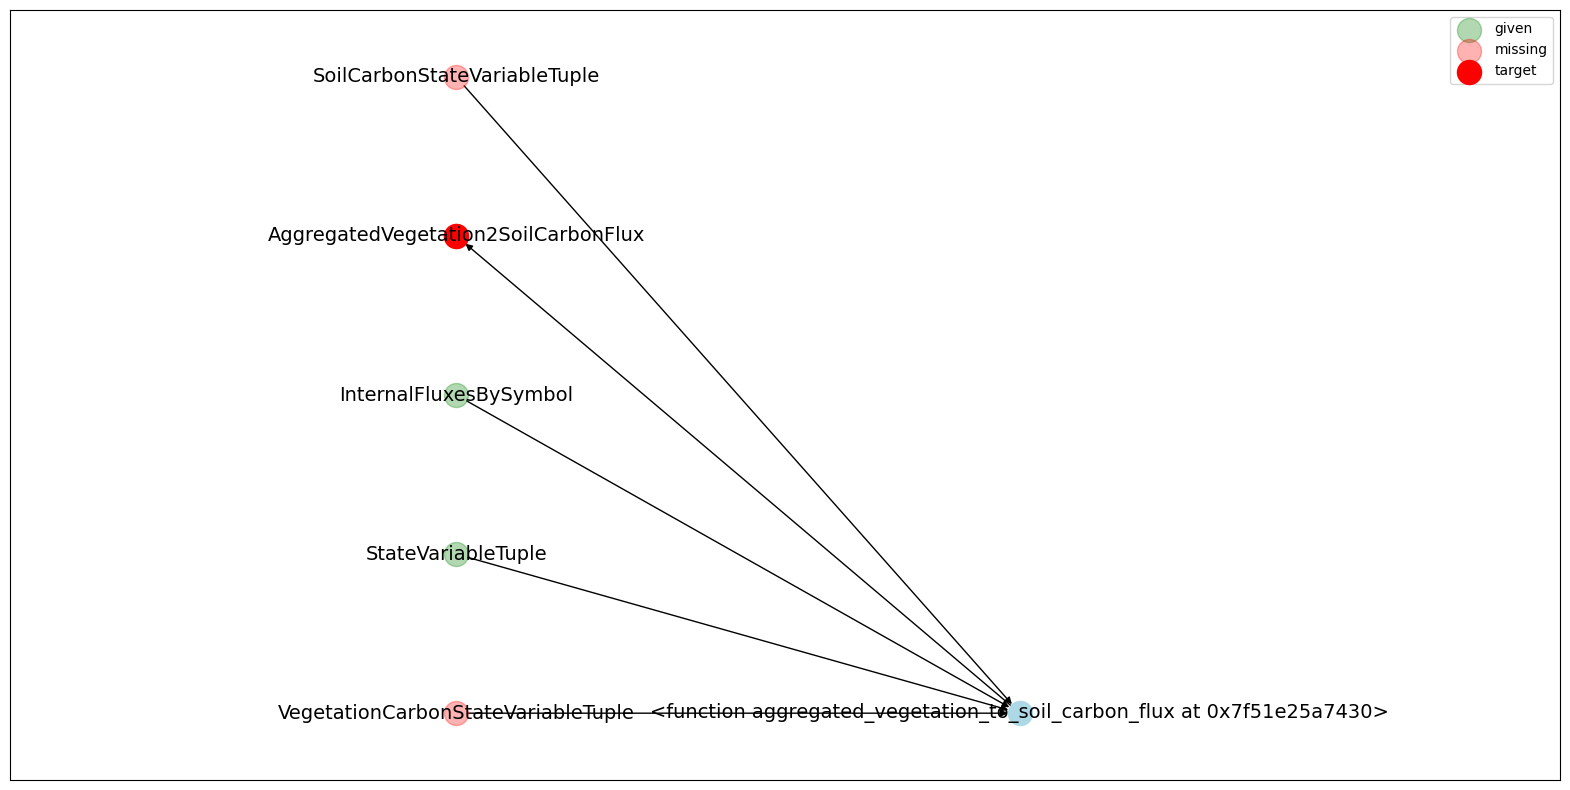

In [19]:
fig=plt.figure(figsize=(20,10))
dg=list(gs)[0]

ax = fig.add_subplot(1, 1, 1)
B=dg.to_bipartite()
mvs.provided_mvar_types.difference(B.types())

B.draw_matplotlib(
    ax,
    given=mvs.provided_mvar_types,
    #computer_aliases=ca,
    #type_aliases=ta
)
#B.draw_matplotlib(ax,target_node=root)

In [62]:
#[n for n in B.nodes if B.out_degree(n)==0]
#dg.jupyter_widget(
#    given=mvs.provided_mvar_types,
#    #computer_aliases=ca,
#    type_aliases=ta
#)

In [64]:
#from bokeh.io import output_file, show, output_notebook
#from ComputabilityGraphs.rec_graph_helpers import fast_graph
#from ComputabilityGraphs.fast_graph_helpers import project_to_multiDiGraph
#from ComputabilityGraphs.graph_plotting import (
#    draw_ComputerSetMultiDiGraph_matplotlib,
#    bokeh_plot
#)
##from frozenset import frozenset
#
#fg = fast_graph(
#    cs=cs,
#    root_type=root,
#    given=mvs.provided_mvar_types
#    #given=frozenset()
#)
#G=project_to_multiDiGraph(fg)
#output_notebook()
##plot=bokeh_plot(G,frozenset({bgc_md2.resolve.mvars.VegetationCarbonCompartmentalMatrix}))
#plot=bokeh_plot(
#    G
#    ,frozenset({bgc_md2.resolve.mvars.VegetationCarbonInFluxesBySymbol})
#)
#show(plot)
##fig=plt.figure(figsize=(20,20))
##ax1 = fig.add_subplot(1, 1, 1)
##fg.draw_matplotlib(
##    ax1
##
##)


In [ ]:

#fig=plt.figure(figsize=(20,20))
#ax1 = fig.add_subplot(1, 1, 1)
#draw_ComputerSetMultiDiGraph_matplotlib(ax=ax1,spsg=project_to_multiDiGraph(fg))